In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import h5py
import seaborn
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import pairwise_distances
import sys
sys.path.append("../")
from utils import l2_normalize, prewhiten, read_sampled_identities, plot_recall, recall_given_dist, plot_topk, EmbeddingsProducer
from PIL import Image
seaborn.set()

In [27]:
def final_dist_from_target(
    adversarial_target,
    identities,
    epsilons,
    path_to_adversarial,
    path_to_clean,
    attack_type,
    model_path=None,
):
    query_embeddings = []
    adv = {eps: [] for eps in epsilons }
    adv_target_indices = {eps: [] for eps in epsilons }

    ep = EmbeddingsProducer(path_to_adversarial.format(
            attack_type=attack_type,
            target='{target}',
            true='{true}',
            epsilon='{epsilon}'
        ), 
        model_path=model_path
    )
    
    with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
        query_embeddings.extend(f["embeddings"][:])

    for modified_identity in identities:
        if modified_identity == adversarial_target:
            continue
        for indx, epsilon in enumerate(epsilons):
            if epsilon == 0.0:
                with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
                    adv_eps = f["embeddings"][:]
                _, adv_ti = ep.get_embeddings(
                    adversarial_target=adversarial_target,
                    modified_identity=modified_identity,
                    epsilon=0.02
                )
            else:
                adv_eps, adv_ti = ep.get_embeddings(
                    adversarial_target=adversarial_target,
                    modified_identity=modified_identity,
                    epsilon=epsilon
                )
            
            if not (adv_eps is None):
                adv[epsilon].extend(adv_eps)
                if not (adv_ti is None):
                    adv_target_indices[epsilon].extend(adv_ti)
                elif attack_type == "community_naive_same":
                    adv_target_indices[epsilon].extend(np.zeros(adv_eps.shape[0]))
                

    query_embeddings = np.array(query_embeddings)
    dist = []          
    for eps in adv_target_indices.keys():
        if attack_type == "community_naive_same" or attack_type == "community_naive_random":
            print("attack type", attack_type, "target indices", adv_target_indices[eps][:5])
            original_targets = np.take(query_embeddings, adv_target_indices[eps], axis=0)
        elif attack_type == "community_naive_mean":
            mean_orig = np.mean(query_embeddings, axis=0)
            original_targets = np.array([mean_orig for _ in range(len(adv[eps]))])
        else:
            raise Exception("Unsupported attack type {}".format(attack_type))
        
        arr = []
        for a, t in zip(adv[eps], original_targets):
            arr.append(pairwise_distances([a], [t])[0])
        dist.append(np.mean(arr))
    return dist
    

In [31]:
def plot_success(
     identities,
     path_to_adversarial,
     path_to_clean,
     epsilons,
     attack_types,
     colors,
     mode,
     model_path=None,
     names=None
 ):
    from matplotlib import pyplot as plt
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for atindx, attack_type in enumerate(attack_types):
        succ_for_targets = []
        for indx, identity in enumerate(["n005359"]):
            succ_for_targets.append(
                final_dist_from_target(
                    identity,
                    identities,
                    epsilons,
                    path_to_adversarial,
                    path_to_clean,
                    attack_type,
                    model_path
            ))
        mean = np.mean(succ_for_targets, axis=0)  
        print(mean.shape)
        print(attack_type, "losses", mean)
        ax.plot(
            list(epsilons),
            mean,
            label=attack_type if names is None else names[atindx],
            color=colors[atindx],
            
         )        

    ax.set_ylabel("Mean distance between final vectors and target")
    ax.set_xlabel("Epsilon (Perturbation Amount)")
    ax.set_ylim([-0.1, 2.0])
    ax.legend()
    plt.show()


In [32]:
kwargs = {
    "path_to_adversarial": "/data/vggface/test_perturbed_sampled/{true}/{attack_type}/{target}/epsilon_{epsilon}.h5",
    "path_to_clean": "/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5",
    "epsilons": [0.0, 0.02, 0.04, 0.06, 0.08, 0.1],
    "identities": read_sampled_identities("../sampled_identities.txt").keys()
}

No embeddings found for /data/vggface/test_perturbed_sampled/n001781/community_naive_same/n005359/epsilon_0.04.h5 []
attack type community_naive_same target indices [0.0, 0.0, 0.0, 0.0, 0.0]
attack type community_naive_same target indices [0.0, 0.0, 0.0, 0.0, 0.0]
attack type community_naive_same target indices [0.0, 0.0, 0.0, 0.0, 0.0]
attack type community_naive_same target indices [0.0, 0.0, 0.0, 0.0, 0.0]
attack type community_naive_same target indices [0.0, 0.0, 0.0, 0.0, 0.0]
attack type community_naive_same target indices [0.0, 0.0, 0.0, 0.0, 0.0]
(6,)
community_naive_same losses [1.3877672  0.9722954  0.59871817 0.35652694 0.24581955 0.18430352]
attack type community_naive_random target indices [37, 22, 15, 3, 24]
attack type community_naive_random target indices [37, 22, 15, 3, 24]
attack type community_naive_random target indices [37, 39, 37, 5, 18]
attack type community_naive_random target indices [5, 34, 47, 17, 0]
attack type community_naive_random target indices [5, 0, 29

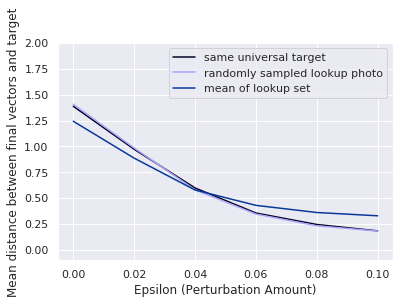

In [33]:
plot_success(
    attack_types=["community_naive_same", "community_naive_random", "community_naive_mean"],
    colors=['#020024', '#aaa5f9', '#073899','#136703', '#00ff2f'],
    mode="recall",
    names=["same universal target", "randomly sampled lookup photo", "mean of lookup set"],
    **kwargs
)

(5,)
(5,)
(5,)


/home/ivan/anaconda3/envs/paf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ivan/anaconda3/envs/paf/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ivan/anaconda3/envs/paf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ivan/anaconda3/envs/paf/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ivan/anaconda3/envs/paf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ivan/anaconda3/envs/paf/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


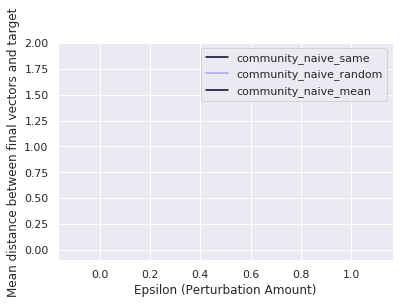

In [6]:
kwargs = {
    "path_to_adversarial": "/data/vggface/test_perturbed_sampled/{true}/{attack_type}/{target}/epsilon_{epsilon}.h5",
    "path_to_clean": "/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5",
    "epsilons": [0.02, 0.04, 0.06, 0.08, 0.1],
    "identities": ["n005359"]
}
plot_success(
    attack_types=["community_naive_same", "community_naive_random", "community_naive_mean"],
    colors=['#020024', '#aaa5f9', '#020024', '#073899','#136703', '#00ff2f'],
    mode="recall",
    **kwargs
)